In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    train_test_split,
    KFold,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import backend as K

In [2]:
project_root = "D:\Projects\Summer-2024-ECE-597-Group8"
data_path = os.path.join(project_root, "data", "processed", "features_bow_labels.csv")
model_path = os.path.join(project_root, 'data', 'models', 'best_cnn_model_bow.keras')
random_state = 42
test_size = 0.1

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\xfy53\AppData\Local\Temp\ipykernel_22212\2122820336.py:1: SyntaxWarning: invalid escape sequence '\P'
  project_root = "D:\Projects\Summer-2024-ECE-597-Group8"


In [3]:
df = pd.read_csv(data_path)
df = df.drop(columns=["js_code"])

In [20]:
def log_transform(x):
    return np.log1p(x)


# Define a custom F1-score metric
def f1_score_metric(y_true, y_pred):
    y_true = K.cast(y_true, "float32")
    y_pred = K.round(K.cast(y_pred, "float32"))
    tp = K.sum(K.cast(y_true * y_pred, "float32"), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), "float32"), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, "float32"), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), "float32"), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    f1 = K.mean(f1)
    return f1


def evaluate_cnn_model(model, X_test, y_test):
    # Predictions - model.predict() directly gives the probabilities for Keras models
    y_proba = model.predict(
        X_test
    ).ravel()  # Ensure it's a 1D array for binary classification
    y_pred = (y_proba > 0.5).astype(
        "int"
    )  # Threshold probabilities to get binary predictions

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced Accuracy:", balanced_acc)

    # ROC-AUC Score
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC-AUC Score:", roc_auc)

    # Precision-Recall Score
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    ap_score = average_precision_score(y_test, y_proba)
    print("Precision-Recall AUC:", pr_auc)
    print("Average Precision Score:", ap_score)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 12))
    plt.subplot(2, 1, 1)
    plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")

    # Precision-Recall Curve
    plt.subplot(2, 1, 2)
    plt.plot(
        recall,
        precision,
        color="blue",
        label=f"Precision-Recall curve (area = {pr_auc:.2f})",
    )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

In [5]:
pipeline_log_transform_StandardScaler = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(log_transform)),
        ("StandardScaler", StandardScaler()),
    ]
)

pipeline_log_transform_RobustScaler = Pipeline(
    steps=[
        ("log_transform", FunctionTransformer(log_transform)),
        ("RobustScaler", RobustScaler()),
    ]
)

features_preprocessor = ColumnTransformer(
    transformers=[
        (
            "features_processer",
            pipeline_log_transform_RobustScaler,
            [
                "Word_Count",
                "Homoglyphs",
                "Total_Abnormal_Count",
                "html_tags",
            ],
        ),
        (
            "bow_processer",
            pipeline_log_transform_StandardScaler,
            [col for col in df.columns if col.startswith('BoW_')]
        ),
    ],
    remainder="passthrough",
)

In [6]:
X = features_preprocessor.fit_transform(df.drop(columns=["Label"]))
y = df["Label"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import optuna


# Reshape the data for CNN
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define the model creation function
def create_model(trial):
    model = Sequential()
    model.add(Input(shape=(X_train_reshaped.shape[1], 1)))
    model.add(Conv1D(filters=trial.suggest_int('filters', 16, 128), 
                     kernel_size=trial.suggest_int('kernel_size', 2, 5), 
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=trial.suggest_int('pool_size', 2, 4)))
    model.add(Conv1D(filters=trial.suggest_int('filters2', 16, 128), 
                     kernel_size=trial.suggest_int('kernel_size2', 2, 5), 
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=trial.suggest_int('pool_size2', 2, 4)))
    model.add(Flatten())
    model.add(Dense(units=trial.suggest_int('units', 32, 256), activation='relu'))
    model.add(Dropout(rate=trial.suggest_float('dropout_rate', 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=trial.suggest_categorical('optimizer', ['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=[f1_score_metric])
    return model

# Define the objective function for Optuna
def objective(trial):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []

    for train_index, valid_index in skf.split(X_train_reshaped, y_train):
        X_t, X_v = X_train_reshaped[train_index], X_train_reshaped[valid_index]
        y_t, y_v = y_train[train_index], y_train[valid_index]

        model = create_model(trial)
        early_stopping = EarlyStopping(monitor='f1_score_metric', min_delta=0.001, patience=10, verbose=1, mode='max', restore_best_weights=True)
        model.fit(X_t, y_t, 
                  epochs=trial.suggest_int('epochs', 10, 50), 
                  batch_size=trial.suggest_int('batch_size', 32, 256),
                  validation_data=(X_v, y_v), 
                  callbacks=[early_stopping], 
                  verbose=0)
        
        y_pred = (model.predict(X_v) > 0.5).astype("int32")
        f1 = f1_score(y_v, y_pred, pos_label=1)
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=6)

# Print the best parameters
print('Best trial:')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-07-11 21:26:56,997] A new study created in memory with name: no-name-05dceeb9-9866-485c-9de8-78f66ed98f95


Restoring model weights from the end of the best epoch: 15.
 85/266 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/stepRestoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
Restoring model weights from the end of the best epoch: 23.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
Restoring model weights from the end of the best epoch: 19.
266/266 ━━

[I 2024-07-11 21:35:31,649] Trial 4 finished with value: 0.8018286786559802 and parameters: {'filters': 100, 'kernel_size': 2, 'pool_size': 3, 'filters2': 111, 'kernel_size2': 5, 'pool_size2': 4, 'units': 226, 'dropout_rate': 0.34310583995509647, 'optimizer': 'rmsprop', 'epochs': 19, 'batch_size': 249}. Best is trial 4 with value: 0.8018286786559802.


Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


[I 2024-07-11 21:36:08,144] Trial 1 finished with value: 0.8414388555490816 and parameters: {'filters': 74, 'kernel_size': 5, 'pool_size': 2, 'filters2': 122, 'kernel_size2': 4, 'pool_size2': 2, 'units': 171, 'dropout_rate': 0.2816108491712567, 'optimizer': 'adam', 'epochs': 14, 'batch_size': 166}. Best is trial 1 with value: 0.8414388555490816.


Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Restoring model weights from the end of the best epoch: 24.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Restoring model weights from the end of the best epoch: 18.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-11 21:39:13,029] Trial 3 finished with value: 0.8206519023658766 and parameters: {'filters': 116, 'kernel_size': 5, 'pool_size': 3, 'filters2': 43, 'kernel_size2': 3, 'pool_size2': 2, 'units': 62, 'dropout_rate': 0.2255634174176035, 'optimizer': 'adam', 'epochs': 45, 'batch_size': 100}. Best is trial 1 with value: 0.8414388555490816.


Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-11 21:40:12,404] Trial 0 finished with value: 0.826093780153764 and parameters: {'filters': 102, 'kernel_size': 3, 'pool_size': 3, 'filters2': 98, 'kernel_size2': 4, 'pool_size2': 2, 'units': 50, 'dropout_rate': 0.4522720703601456, 'optimizer': 'rmsprop', 'epochs': 50, 'batch_size': 124}. Best is trial 1 with value: 0.8414388555490816.


Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 17.
 89/266 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/stepEpoch 21: early stopping
 93/266 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/stepRestoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
148/266 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

[I 2024-07-11 21:41:57,228] Trial 5 finished with value: 0.7717955457167939 and parameters: {'filters': 67, 'kernel_size': 2, 'pool_size': 3, 'filters2': 115, 'kernel_size2': 5, 'pool_size2': 4, 'units': 93, 'dropout_rate': 0.4916545203415624, 'optimizer': 'adam', 'epochs': 27, 'batch_size': 99}. Best is trial 1 with value: 0.8414388555490816.


266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Restoring model weights from the end of the best epoch: 18.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


[I 2024-07-11 21:43:02,573] Trial 2 finished with value: 0.7893729543312408 and parameters: {'filters': 110, 'kernel_size': 2, 'pool_size': 3, 'filters2': 64, 'kernel_size2': 2, 'pool_size2': 3, 'units': 104, 'dropout_rate': 0.36462987372050354, 'optimizer': 'adam', 'epochs': 27, 'batch_size': 97}. Best is trial 1 with value: 0.8414388555490816.


Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 19.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


[I 2024-07-11 21:44:44,750] Trial 7 finished with value: 0.8017881422228662 and parameters: {'filters': 126, 'kernel_size': 5, 'pool_size': 4, 'filters2': 73, 'kernel_size2': 5, 'pool_size2': 4, 'units': 225, 'dropout_rate': 0.24783081114750555, 'optimizer': 'adam', 'epochs': 42, 'batch_size': 231}. Best is trial 1 with value: 0.8414388555490816.


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


[I 2024-07-11 21:45:29,816] Trial 8 finished with value: 0.7789915455859574 and parameters: {'filters': 24, 'kernel_size': 4, 'pool_size': 3, 'filters2': 127, 'kernel_size2': 2, 'pool_size2': 4, 'units': 49, 'dropout_rate': 0.24564842740080645, 'optimizer': 'rmsprop', 'epochs': 35, 'batch_size': 234}. Best is trial 1 with value: 0.8414388555490816.


Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-11 21:48:12,388] Trial 10 finished with value: 0.8006848237285663 and parameters: {'filters': 52, 'kernel_size': 5, 'pool_size': 4, 'filters2': 57, 'kernel_size2': 5, 'pool_size2': 3, 'units': 210, 'dropout_rate': 0.47262016331542517, 'optimizer': 'adam', 'epochs': 37, 'batch_size': 224}. Best is trial 1 with value: 0.8414388555490816.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


[I 2024-07-11 21:50:15,748] Trial 11 finished with value: 0.8188047002686331 and parameters: {'filters': 28, 'kernel_size': 5, 'pool_size': 4, 'filters2': 98, 'kernel_size2': 4, 'pool_size2': 2, 'units': 55, 'dropout_rate': 0.4547923301932995, 'optimizer': 'rmsprop', 'epochs': 23, 'batch_size': 137}. Best is trial 1 with value: 0.8414388555490816.


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


[I 2024-07-11 21:50:46,118] Trial 9 finished with value: 0.8419787218506704 and parameters: {'filters': 84, 'kernel_size': 2, 'pool_size': 2, 'filters2': 74, 'kernel_size2': 3, 'pool_size2': 3, 'units': 155, 'dropout_rate': 0.26392737697906016, 'optimizer': 'rmsprop', 'epochs': 30, 'batch_size': 113}. Best is trial 9 with value: 0.8419787218506704.


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Restoring model weights from the end of the best epoch: 5.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 19.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


[I 2024-07-11 21:53:40,281] Trial 15 finished with value: 0.804259238347741 and parameters: {'filters': 80, 'kernel_size': 4, 'pool_size': 2, 'filters2': 31, 'kernel_size2': 3, 'pool_size2': 2, 'units': 167, 'dropout_rate': 0.319229242102473, 'optimizer': 'adam', 'epochs': 10, 'batch_size': 179}. Best is trial 9 with value: 0.8419787218506704.


Restoring model weights from the end of the best epoch: 7.
245/266 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepEpoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


[I 2024-07-11 21:53:51,545] Trial 12 finished with value: 0.8218316439390992 and parameters: {'filters': 43, 'kernel_size': 5, 'pool_size': 4, 'filters2': 120, 'kernel_size2': 5, 'pool_size2': 4, 'units': 244, 'dropout_rate': 0.39996246940324465, 'optimizer': 'adam', 'epochs': 25, 'batch_size': 115}. Best is trial 9 with value: 0.8419787218506704.


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


[I 2024-07-11 21:55:57,743] Trial 6 finished with value: 0.8368091365802831 and parameters: {'filters': 90, 'kernel_size': 3, 'pool_size': 2, 'filters2': 87, 'kernel_size2': 5, 'pool_size2': 4, 'units': 110, 'dropout_rate': 0.2948905382115783, 'optimizer': 'rmsprop', 'epochs': 41, 'batch_size': 44}. Best is trial 9 with value: 0.8419787218506704.


Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


[I 2024-07-11 21:56:51,013] Trial 14 finished with value: 0.8292381211178635 and parameters: {'filters': 25, 'kernel_size': 3, 'pool_size': 2, 'filters2': 91, 'kernel_size2': 3, 'pool_size2': 4, 'units': 163, 'dropout_rate': 0.25159369697864653, 'optimizer': 'rmsprop', 'epochs': 29, 'batch_size': 91}. Best is trial 9 with value: 0.8419787218506704.


Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 24.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-11 21:57:59,850] Trial 13 finished with value: 0.8379624242958607 and parameters: {'filters': 114, 'kernel_size': 3, 'pool_size': 2, 'filters2': 112, 'kernel_size2': 2, 'pool_size2': 2, 'units': 74, 'dropout_rate': 0.4565478494670575, 'optimizer': 'adam', 'epochs': 50, 'batch_size': 181}. Best is trial 9 with value: 0.8419787218506704.


Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Restoring model weights from the end of the best epoch: 9.
 49/266 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/stepRestoring model weights from the end of the best epoch: 7.
 71/266 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/stepRestoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
157/266 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/stepRestoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
Restoring model weights from the end of the best epoch: 8.


[I 2024-07-11 21:59:38,803] Trial 16 finished with value: 0.8185849999183333 and parameters: {'filters': 80, 'kernel_size': 3, 'pool_size': 2, 'filters2': 16, 'kernel_size2': 3, 'pool_size2': 3, 'units': 166, 'dropout_rate': 0.3063886145847603, 'optimizer': 'rmsprop', 'epochs': 13, 'batch_size': 35}. Best is trial 9 with value: 0.8419787218506704.


266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


[I 2024-07-11 21:59:44,075] Trial 19 finished with value: 0.8089676727097718 and parameters: {'filters': 66, 'kernel_size': 3, 'pool_size': 2, 'filters2': 76, 'kernel_size2': 3, 'pool_size2': 3, 'units': 175, 'dropout_rate': 0.20222894162987579, 'optimizer': 'rmsprop', 'epochs': 10, 'batch_size': 173}. Best is trial 9 with value: 0.8419787218506704.


Restoring model weights from the end of the best epoch: 5.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


[I 2024-07-11 22:00:54,390] Trial 20 finished with value: 0.817889536672133 and parameters: {'filters': 68, 'kernel_size': 4, 'pool_size': 2, 'filters2': 26, 'kernel_size2': 4, 'pool_size2': 3, 'units': 137, 'dropout_rate': 0.2942692610574586, 'optimizer': 'rmsprop', 'epochs': 13, 'batch_size': 175}. Best is trial 9 with value: 0.8419787218506704.


Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


[I 2024-07-11 22:02:30,516] Trial 17 finished with value: 0.8409734669078729 and parameters: {'filters': 82, 'kernel_size': 3, 'pool_size': 2, 'filters2': 83, 'kernel_size2': 3, 'pool_size2': 3, 'units': 167, 'dropout_rate': 0.2946574912970075, 'optimizer': 'rmsprop', 'epochs': 10, 'batch_size': 39}. Best is trial 9 with value: 0.8419787218506704.


Restoring model weights from the end of the best epoch: 18.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Restoring model weights from the end of the best epoch: 18.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


[I 2024-07-11 22:03:05,594] Trial 21 finished with value: 0.8430000026658199 and parameters: {'filters': 64, 'kernel_size': 4, 'pool_size': 2, 'filters2': 16, 'kernel_size2': 4, 'pool_size2': 3, 'units': 135, 'dropout_rate': 0.2851945023769353, 'optimizer': 'rmsprop', 'epochs': 18, 'batch_size': 161}. Best is trial 21 with value: 0.8430000026658199.


Restoring model weights from the end of the best epoch: 6.
 98/266 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/stepRestoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
161/266 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

[I 2024-07-11 22:03:16,903] Trial 18 finished with value: 0.8372921771913844 and parameters: {'filters': 84, 'kernel_size': 3, 'pool_size': 2, 'filters2': 88, 'kernel_size2': 3, 'pool_size2': 3, 'units': 166, 'dropout_rate': 0.29399804576526367, 'optimizer': 'rmsprop', 'epochs': 11, 'batch_size': 41}. Best is trial 21 with value: 0.8430000026658199.


266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 12.
265/266 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/stepRestoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Restoring model weights from the end of the best epoch: 14.


[I 2024-07-11 22:05:25,749] Trial 22 finished with value: 0.8225169032695385 and parameters: {'filters': 62, 'kernel_size': 4, 'pool_size': 2, 'filters2': 76, 'kernel_size2': 4, 'pool_size2': 3, 'units': 128, 'dropout_rate': 0.20170086471196108, 'optimizer': 'rmsprop', 'epochs': 15, 'batch_size': 168}. Best is trial 21 with value: 0.8430000026658199.


266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-11 22:06:19,054] Trial 24 finished with value: 0.8579260664434103 and parameters: {'filters': 49, 'kernel_size': 4, 'pool_size': 2, 'filters2': 48, 'kernel_size2': 4, 'pool_size2': 2, 'units': 192, 'dropout_rate': 0.27825117109821107, 'optimizer': 'adam', 'epochs': 18, 'batch_size': 202}. Best is trial 24 with value: 0.8579260664434103.


Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


[I 2024-07-11 22:06:37,847] Trial 23 finished with value: 0.8176180694955146 and parameters: {'filters': 55, 'kernel_size': 4, 'pool_size': 2, 'filters2': 50, 'kernel_size2': 4, 'pool_size2': 3, 'units': 130, 'dropout_rate': 0.2845216682577066, 'optimizer': 'adam', 'epochs': 19, 'batch_size': 157}. Best is trial 24 with value: 0.8579260664434103.


Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-11 22:09:38,618] Trial 26 finished with value: 0.8312636037832465 and parameters: {'filters': 54, 'kernel_size': 4, 'pool_size': 2, 'filters2': 48, 'kernel_size2': 4, 'pool_size2': 3, 'units': 130, 'dropout_rate': 0.268631520943248, 'optimizer': 'rmsprop', 'epochs': 18, 'batch_size': 156}. Best is trial 24 with value: 0.8579260664434103.


Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


[I 2024-07-11 22:09:56,101] Trial 27 finished with value: 0.836929236025294 and parameters: {'filters': 54, 'kernel_size': 4, 'pool_size': 2, 'filters2': 52, 'kernel_size2': 4, 'pool_size2': 2, 'units': 135, 'dropout_rate': 0.2684410680056393, 'optimizer': 'rmsprop', 'epochs': 18, 'batch_size': 149}. Best is trial 24 with value: 0.8579260664434103.


Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Restoring model weights from the end of the best epoch: 11.
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepEpoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Restoring model weights from the end of the best epoch: 18.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


[I 2024-07-11 22:11:13,776] Trial 28 finished with value: 0.8485538376969499 and parameters: {'filters': 50, 'kernel_size': 4, 'pool_size': 2, 'filters2': 55, 'kernel_size2': 4, 'pool_size2': 2, 'units': 195, 'dropout_rate': 0.26956806931934296, 'optimizer': 'adam', 'epochs': 19, 'batch_size': 202}. Best is trial 24 with value: 0.8579260664434103.


Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
 83/266 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/stepEpoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


[I 2024-07-11 22:11:34,284] Trial 30 finished with value: 0.8234775269411183 and parameters: {'filters': 35, 'kernel_size': 4, 'pool_size': 3, 'filters2': 41, 'kernel_size2': 4, 'pool_size2': 2, 'units': 195, 'dropout_rate': 0.3433588951378714, 'optimizer': 'rmsprop', 'epochs': 20, 'batch_size': 198}. Best is trial 24 with value: 0.8579260664434103.


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


[I 2024-07-11 22:11:57,415] Trial 29 finished with value: 0.8418449500301914 and parameters: {'filters': 42, 'kernel_size': 4, 'pool_size': 2, 'filters2': 52, 'kernel_size2': 4, 'pool_size2': 3, 'units': 191, 'dropout_rate': 0.33558671024301734, 'optimizer': 'rmsprop', 'epochs': 20, 'batch_size': 203}. Best is trial 24 with value: 0.8579260664434103.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 17.
 65/266 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


[I 2024-07-11 22:13:25,666] Trial 25 finished with value: 0.8452470824743691 and parameters: {'filters': 54, 'kernel_size': 4, 'pool_size': 2, 'filters2': 51, 'kernel_size2': 4, 'pool_size2': 2, 'units': 196, 'dropout_rate': 0.3943535664115866, 'optimizer': 'adam', 'epochs': 20, 'batch_size': 74}. Best is trial 24 with value: 0.8579260664434103.


Restoring model weights from the end of the best epoch: 21.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


[I 2024-07-11 22:14:31,137] Trial 31 finished with value: 0.8316258676655693 and parameters: {'filters': 42, 'kernel_size': 4, 'pool_size': 3, 'filters2': 29, 'kernel_size2': 4, 'pool_size2': 2, 'units': 195, 'dropout_rate': 0.3424131798846325, 'optimizer': 'rmsprop', 'epochs': 34, 'batch_size': 205}. Best is trial 24 with value: 0.8579260664434103.


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


[I 2024-07-11 22:15:09,003] Trial 32 finished with value: 0.8196980775034515 and parameters: {'filters': 39, 'kernel_size': 2, 'pool_size': 3, 'filters2': 40, 'kernel_size2': 4, 'pool_size2': 2, 'units': 200, 'dropout_rate': 0.3306570129192841, 'optimizer': 'rmsprop', 'epochs': 32, 'batch_size': 201}. Best is trial 24 with value: 0.8579260664434103.


Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


[I 2024-07-11 22:16:07,190] Trial 33 finished with value: 0.8294599204067069 and parameters: {'filters': 38, 'kernel_size': 4, 'pool_size': 3, 'filters2': 38, 'kernel_size2': 4, 'pool_size2': 2, 'units': 193, 'dropout_rate': 0.3449305689016199, 'optimizer': 'adam', 'epochs': 23, 'batch_size': 204}. Best is trial 24 with value: 0.8579260664434103.


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


[I 2024-07-11 22:16:25,126] Trial 35 finished with value: 0.8225635002253678 and parameters: {'filters': 17, 'kernel_size': 4, 'pool_size': 3, 'filters2': 34, 'kernel_size2': 4, 'pool_size2': 2, 'units': 256, 'dropout_rate': 0.38174449951495015, 'optimizer': 'adam', 'epochs': 22, 'batch_size': 205}. Best is trial 24 with value: 0.8579260664434103.


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


[I 2024-07-11 22:16:33,061] Trial 34 finished with value: 0.8124921044680011 and parameters: {'filters': 44, 'kernel_size': 4, 'pool_size': 3, 'filters2': 33, 'kernel_size2': 4, 'pool_size2': 2, 'units': 193, 'dropout_rate': 0.3949705583983794, 'optimizer': 'adam', 'epochs': 23, 'batch_size': 198}. Best is trial 24 with value: 0.8579260664434103.


Restoring model weights from the end of the best epoch: 19.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


[I 2024-07-11 22:19:57,069] Trial 36 finished with value: 0.8467825963119641 and parameters: {'filters': 44, 'kernel_size': 4, 'pool_size': 2, 'filters2': 63, 'kernel_size2': 4, 'pool_size2': 2, 'units': 188, 'dropout_rate': 0.38471677789679976, 'optimizer': 'adam', 'epochs': 23, 'batch_size': 202}. Best is trial 24 with value: 0.8579260664434103.


Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Restoring model weights from the end of the best epoch: 10.
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━

[I 2024-07-11 22:25:03,460] Trial 40 finished with value: 0.845771617760425 and parameters: {'filters': 48, 'kernel_size': 5, 'pool_size': 2, 'filters2': 63, 'kernel_size2': 4, 'pool_size2': 2, 'units': 212, 'dropout_rate': 0.4092596224789147, 'optimizer': 'adam', 'epochs': 16, 'batch_size': 76}. Best is trial 24 with value: 0.8579260664434103.


Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


[I 2024-07-11 22:26:08,736] Trial 37 finished with value: 0.853601940660431 and parameters: {'filters': 17, 'kernel_size': 4, 'pool_size': 2, 'filters2': 62, 'kernel_size2': 4, 'pool_size2': 2, 'units': 213, 'dropout_rate': 0.4057913037250389, 'optimizer': 'adam', 'epochs': 23, 'batch_size': 70}. Best is trial 24 with value: 0.8579260664434103.


Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


[I 2024-07-11 22:26:18,656] Trial 38 finished with value: 0.830372077642879 and parameters: {'filters': 49, 'kernel_size': 4, 'pool_size': 2, 'filters2': 64, 'kernel_size2': 4, 'pool_size2': 2, 'units': 252, 'dropout_rate': 0.3957143722362122, 'optimizer': 'adam', 'epochs': 23, 'batch_size': 69}. Best is trial 24 with value: 0.8579260664434103.


Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


[I 2024-07-11 22:27:27,300] Trial 41 finished with value: 0.8453615119622745 and parameters: {'filters': 60, 'kernel_size': 5, 'pool_size': 2, 'filters2': 65, 'kernel_size2': 5, 'pool_size2': 2, 'units': 212, 'dropout_rate': 0.2268552869667742, 'optimizer': 'adam', 'epochs': 16, 'batch_size': 66}. Best is trial 24 with value: 0.8579260664434103.


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
105/266 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/stepRestoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Restoring model weights from the end of the best epoch: 20.
 54/266 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/stepRestoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


[I 2024-07-11 22:30:05,714] Trial 39 finished with value: 0.8589754274602033 and parameters: {'filters': 16, 'kernel_size': 4, 'pool_size': 2, 'filters2': 64, 'kernel_size2': 4, 'pool_size2': 2, 'units': 218, 'dropout_rate': 0.37795499819241474, 'optimizer': 'adam', 'epochs': 22, 'batch_size': 56}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


[I 2024-07-11 22:30:12,576] Trial 43 finished with value: 0.8381589874587267 and parameters: {'filters': 32, 'kernel_size': 5, 'pool_size': 2, 'filters2': 63, 'kernel_size2': 5, 'pool_size2': 2, 'units': 222, 'dropout_rate': 0.43394048964764265, 'optimizer': 'adam', 'epochs': 16, 'batch_size': 219}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


[I 2024-07-11 22:30:31,232] Trial 42 finished with value: 0.8547240873885245 and parameters: {'filters': 49, 'kernel_size': 5, 'pool_size': 2, 'filters2': 61, 'kernel_size2': 5, 'pool_size2': 2, 'units': 220, 'dropout_rate': 0.4193517878649493, 'optimizer': 'adam', 'epochs': 16, 'batch_size': 73}. Best is trial 39 with value: 0.8589754274602033.


Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
195/266 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/stepRestoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Restoring model weights from the end of the best epoch: 19.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Restoring model weights from the end of the best epoch: 21.
 46/266 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/stepRestoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
256/266 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepEpoch 19: early stopping
259/266 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepRestoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
 22/266 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step

[I 2024-07-11 22:33:14,289] Trial 46 finished with value: 0.8443432890084592 and parameters: {'filters': 32, 'kernel_size': 5, 'pool_size': 2, 'filters2': 59, 'kernel_size2': 5, 'pool_size2': 2, 'units': 228, 'dropout_rate': 0.35852918429401176, 'optimizer': 'adam', 'epochs': 16, 'batch_size': 218}. Best is trial 39 with value: 0.8589754274602033.


266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


[I 2024-07-11 22:33:19,897] Trial 44 finished with value: 0.8388669557030647 and parameters: {'filters': 31, 'kernel_size': 5, 'pool_size': 2, 'filters2': 66, 'kernel_size2': 5, 'pool_size2': 2, 'units': 232, 'dropout_rate': 0.3639776368930799, 'optimizer': 'adam', 'epochs': 26, 'batch_size': 251}. Best is trial 39 with value: 0.8589754274602033.


Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
151/266 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/stepEpoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
121/266 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

[I 2024-07-11 22:34:54,306] Trial 45 finished with value: 0.8543258667680728 and parameters: {'filters': 32, 'kernel_size': 5, 'pool_size': 2, 'filters2': 61, 'kernel_size2': 5, 'pool_size2': 2, 'units': 232, 'dropout_rate': 0.43489610875352686, 'optimizer': 'adam', 'epochs': 26, 'batch_size': 217}. Best is trial 39 with value: 0.8589754274602033.


261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepEpoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step
Restoring model weights from the end of the best epoch: 19.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Restoring model weights from the end of the best epoch: 18.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


[I 2024-07-11 22:37:10,108] Trial 48 finished with value: 0.850853811602951 and parameters: {'filters': 17, 'kernel_size': 4, 'pool_size': 2, 'filters2': 58, 'kernel_size2': 5, 'pool_size2': 2, 'units': 235, 'dropout_rate': 0.37315556405436, 'optimizer': 'adam', 'epochs': 26, 'batch_size': 254}. Best is trial 39 with value: 0.8589754274602033.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


[I 2024-07-11 22:37:25,745] Trial 47 finished with value: 0.8402571155850457 and parameters: {'filters': 30, 'kernel_size': 4, 'pool_size': 2, 'filters2': 59, 'kernel_size2': 5, 'pool_size2': 2, 'units': 231, 'dropout_rate': 0.41932847251247596, 'optimizer': 'adam', 'epochs': 27, 'batch_size': 256}. Best is trial 39 with value: 0.8589754274602033.


Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━

[I 2024-07-11 22:42:53,723] Trial 49 finished with value: 0.8524799473312569 and parameters: {'filters': 16, 'kernel_size': 5, 'pool_size': 2, 'filters2': 57, 'kernel_size2': 5, 'pool_size2': 2, 'units': 235, 'dropout_rate': 0.3620803691401356, 'optimizer': 'adam', 'epochs': 26, 'batch_size': 53}. Best is trial 39 with value: 0.8589754274602033.


Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
261/266 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepEpoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-11 22:44:10,454] Trial 51 finished with value: 0.8486014749831297 and parameters: {'filters': 19, 'kernel_size': 5, 'pool_size': 2, 'filters2': 69, 'kernel_size2': 5, 'pool_size2': 2, 'units': 180, 'dropout_rate': 0.4188878536741566, 'optimizer': 'adam', 'epochs': 26, 'batch_size': 56}. Best is trial 39 with value: 0.8589754274602033.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


[I 2024-07-11 22:45:22,030] Trial 50 finished with value: 0.8493596802254507 and parameters: {'filters': 17, 'kernel_size': 5, 'pool_size': 2, 'filters2': 70, 'kernel_size2': 5, 'pool_size2': 2, 'units': 237, 'dropout_rate': 0.4250088127344095, 'optimizer': 'adam', 'epochs': 26, 'batch_size': 52}. Best is trial 39 with value: 0.8589754274602033.


Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


[I 2024-07-11 22:46:28,605] Trial 52 finished with value: 0.8516346901616441 and parameters: {'filters': 17, 'kernel_size': 5, 'pool_size': 2, 'filters2': 69, 'kernel_size2': 5, 'pool_size2': 2, 'units': 237, 'dropout_rate': 0.4246083884955178, 'optimizer': 'adam', 'epochs': 29, 'batch_size': 55}. Best is trial 39 with value: 0.8589754274602033.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


[I 2024-07-11 22:47:26,816] Trial 53 finished with value: 0.8336917294552656 and parameters: {'filters': 21, 'kernel_size': 5, 'pool_size': 2, 'filters2': 69, 'kernel_size2': 5, 'pool_size2': 2, 'units': 34, 'dropout_rate': 0.4257725445404047, 'optimizer': 'adam', 'epochs': 29, 'batch_size': 54}. Best is trial 39 with value: 0.8589754274602033.


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
263/266 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/stepEpoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


[I 2024-07-11 22:48:28,954] Trial 54 finished with value: 0.8550330911475044 and parameters: {'filters': 22, 'kernel_size': 5, 'pool_size': 2, 'filters2': 45, 'kernel_size2': 5, 'pool_size2': 2, 'units': 244, 'dropout_rate': 0.43802679058353516, 'optimizer': 'adam', 'epochs': 29, 'batch_size': 49}. Best is trial 39 with value: 0.8589754274602033.


266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
 43/266 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/stepEpoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
236/266 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15m

[I 2024-07-11 22:51:32,788] Trial 57 finished with value: 0.8299855451276613 and parameters: {'filters': 23, 'kernel_size': 5, 'pool_size': 2, 'filters2': 45, 'kernel_size2': 5, 'pool_size2': 2, 'units': 219, 'dropout_rate': 0.4456061237155816, 'optimizer': 'adam', 'epochs': 21, 'batch_size': 88}. Best is trial 39 with value: 0.8589754274602033.


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
 74/266 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/stepEpoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
154/266 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

[I 2024-07-11 22:51:39,686] Trial 55 finished with value: 0.8361926072785707 and parameters: {'filters': 23, 'kernel_size': 5, 'pool_size': 3, 'filters2': 45, 'kernel_size2': 5, 'pool_size2': 2, 'units': 216, 'dropout_rate': 0.4369946710285692, 'optimizer': 'adam', 'epochs': 30, 'batch_size': 54}. Best is trial 39 with value: 0.8589754274602033.


266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


[I 2024-07-11 22:53:56,379] Trial 59 finished with value: 0.8445650494672506 and parameters: {'filters': 22, 'kernel_size': 5, 'pool_size': 2, 'filters2': 44, 'kernel_size2': 2, 'pool_size2': 2, 'units': 217, 'dropout_rate': 0.44350506055813166, 'optimizer': 'adam', 'epochs': 21, 'batch_size': 89}. Best is trial 39 with value: 0.8589754274602033.


Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
 68/266 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/stepEpoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


[I 2024-07-11 22:54:16,372] Trial 58 finished with value: 0.8500001171561574 and parameters: {'filters': 23, 'kernel_size': 5, 'pool_size': 2, 'filters2': 45, 'kernel_size2': 5, 'pool_size2': 2, 'units': 208, 'dropout_rate': 0.4430929092744146, 'optimizer': 'adam', 'epochs': 29, 'batch_size': 84}. Best is trial 39 with value: 0.8589754274602033.


Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 19.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


[I 2024-07-11 22:55:23,268] Trial 56 finished with value: 0.8532113497451724 and parameters: {'filters': 22, 'kernel_size': 5, 'pool_size': 2, 'filters2': 71, 'kernel_size2': 5, 'pool_size2': 2, 'units': 240, 'dropout_rate': 0.43854439839491977, 'optimizer': 'adam', 'epochs': 29, 'batch_size': 55}. Best is trial 39 with value: 0.8589754274602033.


Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
102/266 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/stepEpoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
150/266 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

[I 2024-07-11 22:56:25,304] Trial 60 finished with value: 0.8505619478447267 and parameters: {'filters': 25, 'kernel_size': 5, 'pool_size': 2, 'filters2': 45, 'kernel_size2': 2, 'pool_size2': 2, 'units': 218, 'dropout_rate': 0.47522863809517313, 'optimizer': 'adam', 'epochs': 32, 'batch_size': 88}. Best is trial 39 with value: 0.8589754274602033.


266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


[I 2024-07-11 22:57:42,150] Trial 62 finished with value: 0.8258782570166722 and parameters: {'filters': 26, 'kernel_size': 5, 'pool_size': 4, 'filters2': 46, 'kernel_size2': 2, 'pool_size2': 2, 'units': 246, 'dropout_rate': 0.4874698926986354, 'optimizer': 'adam', 'epochs': 32, 'batch_size': 129}. Best is trial 39 with value: 0.8589754274602033.


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
255/266 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepEpoch 25: early stopping
Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
 91/266 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/stepRestoring model weights from the end of the best epoch: 22.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
264/266 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepEpoch 32: early stopping
Restoring model weights from th

[I 2024-07-11 23:01:42,387] Trial 64 finished with value: 0.8047163410704231 and parameters: {'filters': 27, 'kernel_size': 3, 'pool_size': 4, 'filters2': 77, 'kernel_size2': 3, 'pool_size2': 2, 'units': 249, 'dropout_rate': 0.47177436888457663, 'optimizer': 'adam', 'epochs': 37, 'batch_size': 129}. Best is trial 39 with value: 0.8589754274602033.


266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


[I 2024-07-11 23:02:42,290] Trial 61 finished with value: 0.8439400319792772 and parameters: {'filters': 25, 'kernel_size': 5, 'pool_size': 4, 'filters2': 80, 'kernel_size2': 2, 'pool_size2': 2, 'units': 243, 'dropout_rate': 0.4930110338193546, 'optimizer': 'adam', 'epochs': 31, 'batch_size': 87}. Best is trial 39 with value: 0.8589754274602033.


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


[I 2024-07-11 23:03:21,011] Trial 63 finished with value: 0.8515632058981694 and parameters: {'filters': 28, 'kernel_size': 5, 'pool_size': 2, 'filters2': 80, 'kernel_size2': 5, 'pool_size2': 2, 'units': 246, 'dropout_rate': 0.4708407758398376, 'optimizer': 'adam', 'epochs': 38, 'batch_size': 125}. Best is trial 39 with value: 0.8589754274602033.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


[I 2024-07-11 23:04:37,422] Trial 66 finished with value: 0.8467543514433467 and parameters: {'filters': 28, 'kernel_size': 5, 'pool_size': 2, 'filters2': 80, 'kernel_size2': 5, 'pool_size2': 2, 'units': 247, 'dropout_rate': 0.46919570665017946, 'optimizer': 'adam', 'epochs': 38, 'batch_size': 240}. Best is trial 39 with value: 0.8589754274602033.


Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


[I 2024-07-11 23:05:37,069] Trial 65 finished with value: 0.8219091043006922 and parameters: {'filters': 27, 'kernel_size': 3, 'pool_size': 4, 'filters2': 81, 'kernel_size2': 3, 'pool_size2': 2, 'units': 208, 'dropout_rate': 0.4721123405141588, 'optimizer': 'adam', 'epochs': 37, 'batch_size': 107}. Best is trial 39 with value: 0.8589754274602033.


Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 14.
 39/266 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/stepEpoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
266/266 ━━━━━

[I 2024-07-11 23:16:00,016] Trial 69 finished with value: 0.8531249252583386 and parameters: {'filters': 72, 'kernel_size': 5, 'pool_size': 2, 'filters2': 53, 'kernel_size2': 5, 'pool_size2': 2, 'units': 207, 'dropout_rate': 0.41047569069012874, 'optimizer': 'adam', 'epochs': 24, 'batch_size': 107}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Restoring model weights from the end of the best epoch: 21.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


[I 2024-07-11 23:17:34,357] Trial 70 finished with value: 0.8447847122919557 and parameters: {'filters': 98, 'kernel_size': 5, 'pool_size': 2, 'filters2': 99, 'kernel_size2': 5, 'pool_size2': 2, 'units': 203, 'dropout_rate': 0.4589188429214745, 'optimizer': 'adam', 'epochs': 24, 'batch_size': 240}. Best is trial 39 with value: 0.8589754274602033.


Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step


[I 2024-07-11 23:19:47,048] Trial 67 finished with value: 0.8573747843148188 and parameters: {'filters': 74, 'kernel_size': 5, 'pool_size': 2, 'filters2': 80, 'kernel_size2': 5, 'pool_size2': 2, 'units': 246, 'dropout_rate': 0.4631684579622555, 'optimizer': 'adam', 'epochs': 24, 'batch_size': 44}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-11 23:21:07,612] Trial 71 finished with value: 0.8568918304230202 and parameters: {'filters': 37, 'kernel_size': 3, 'pool_size': 2, 'filters2': 95, 'kernel_size2': 5, 'pool_size2': 2, 'units': 204, 'dropout_rate': 0.4050880698753481, 'optimizer': 'adam', 'epochs': 13, 'batch_size': 33}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


[I 2024-07-11 23:22:35,872] Trial 72 finished with value: 0.8513973734445465 and parameters: {'filters': 36, 'kernel_size': 5, 'pool_size': 2, 'filters2': 53, 'kernel_size2': 5, 'pool_size2': 2, 'units': 225, 'dropout_rate': 0.40732689037486175, 'optimizer': 'adam', 'epochs': 24, 'batch_size': 44}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


[I 2024-07-11 23:25:22,249] Trial 68 finished with value: 0.8509478024574157 and parameters: {'filters': 36, 'kernel_size': 5, 'pool_size': 2, 'filters2': 83, 'kernel_size2': 5, 'pool_size2': 2, 'units': 203, 'dropout_rate': 0.4087212239522079, 'optimizer': 'adam', 'epochs': 24, 'batch_size': 32}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


[I 2024-07-11 23:29:20,964] Trial 74 finished with value: 0.8508895389648844 and parameters: {'filters': 60, 'kernel_size': 4, 'pool_size': 2, 'filters2': 74, 'kernel_size2': 5, 'pool_size2': 2, 'units': 155, 'dropout_rate': 0.38359937529244503, 'optimizer': 'adam', 'epochs': 12, 'batch_size': 33}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


[I 2024-07-11 23:29:47,365] Trial 73 finished with value: 0.8434852665026537 and parameters: {'filters': 101, 'kernel_size': 4, 'pool_size': 2, 'filters2': 55, 'kernel_size2': 5, 'pool_size2': 4, 'units': 225, 'dropout_rate': 0.4056285705514487, 'optimizer': 'adam', 'epochs': 13, 'batch_size': 33}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Restoring model weights from the end of the best epoch: 8.
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


[I 2024-07-11 23:34:20,141] Trial 75 finished with value: 0.8364961730355028 and parameters: {'filters': 74, 'kernel_size': 4, 'pool_size': 2, 'filters2': 92, 'kernel_size2': 4, 'pool_size2': 4, 'units': 224, 'dropout_rate': 0.45534741951686153, 'optimizer': 'adam', 'epochs': 14, 'batch_size': 35}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-11 23:35:07,698] Trial 78 finished with value: 0.8380850829192036 and parameters: {'filters': 58, 'kernel_size': 2, 'pool_size': 2, 'filters2': 96, 'kernel_size2': 5, 'pool_size2': 2, 'units': 180, 'dropout_rate': 0.38774951464759905, 'optimizer': 'adam', 'epochs': 12, 'batch_size': 63}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step


[I 2024-07-11 23:36:21,207] Trial 79 finished with value: 0.7808551573351753 and parameters: {'filters': 71, 'kernel_size': 2, 'pool_size': 2, 'filters2': 94, 'kernel_size2': 4, 'pool_size2': 4, 'units': 225, 'dropout_rate': 0.4595593821543354, 'optimizer': 'adam', 'epochs': 14, 'batch_size': 189}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


[I 2024-07-11 23:37:08,407] Trial 77 finished with value: 0.8355447859927043 and parameters: {'filters': 89, 'kernel_size': 2, 'pool_size': 2, 'filters2': 90, 'kernel_size2': 5, 'pool_size2': 4, 'units': 177, 'dropout_rate': 0.38210011793322674, 'optimizer': 'adam', 'epochs': 12, 'batch_size': 33}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


[I 2024-07-11 23:38:29,126] Trial 76 finished with value: 0.8506644904724093 and parameters: {'filters': 76, 'kernel_size': 3, 'pool_size': 2, 'filters2': 94, 'kernel_size2': 5, 'pool_size2': 2, 'units': 185, 'dropout_rate': 0.40913003148906457, 'optimizer': 'adam', 'epochs': 13, 'batch_size': 32}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


[I 2024-07-11 23:46:04,002] Trial 80 finished with value: 0.8569484661318127 and parameters: {'filters': 75, 'kernel_size': 2, 'pool_size': 2, 'filters2': 102, 'kernel_size2': 4, 'pool_size2': 2, 'units': 183, 'dropout_rate': 0.3883416949181884, 'optimizer': 'adam', 'epochs': 17, 'batch_size': 63}. Best is trial 39 with value: 0.8589754274602033.


Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Restoring model weights from the end of the best epoch: 9.
129/266 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/stepRestoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
 88/266 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step

[I 2024-07-11 23:48:53,931] Trial 83 finished with value: 0.8411077725583502 and parameters: {'filters': 39, 'kernel_size': 3, 'pool_size': 2, 'filters2': 103, 'kernel_size2': 4, 'pool_size2': 2, 'units': 112, 'dropout_rate': 0.31088981184192427, 'optimizer': 'adam', 'epochs': 17, 'batch_size': 77}. Best is trial 39 with value: 0.8589754274602033.


266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


[I 2024-07-11 23:52:32,326] Trial 84 finished with value: 0.8505409469154697 and parameters: {'filters': 47, 'kernel_size': 3, 'pool_size': 2, 'filters2': 110, 'kernel_size2': 4, 'pool_size2': 2, 'units': 230, 'dropout_rate': 0.3712985884283449, 'optimizer': 'adam', 'epochs': 18, 'batch_size': 78}. Best is trial 39 with value: 0.8589754274602033.


Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


[I 2024-07-11 23:57:40,709] Trial 82 finished with value: 0.8593766594874016 and parameters: {'filters': 122, 'kernel_size': 3, 'pool_size': 2, 'filters2': 61, 'kernel_size2': 4, 'pool_size2': 2, 'units': 255, 'dropout_rate': 0.3716489107063351, 'optimizer': 'adam', 'epochs': 18, 'batch_size': 44}. Best is trial 82 with value: 0.8593766594874016.


Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


[I 2024-07-11 23:59:31,193] Trial 85 finished with value: 0.8603585951523648 and parameters: {'filters': 40, 'kernel_size': 3, 'pool_size': 2, 'filters2': 100, 'kernel_size2': 4, 'pool_size2': 2, 'units': 252, 'dropout_rate': 0.3739257235585098, 'optimizer': 'adam', 'epochs': 17, 'batch_size': 45}. Best is trial 85 with value: 0.8603585951523648.


Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step


[I 2024-07-12 00:00:29,292] Trial 81 finished with value: 0.8414255018742697 and parameters: {'filters': 90, 'kernel_size': 2, 'pool_size': 2, 'filters2': 100, 'kernel_size2': 4, 'pool_size2': 2, 'units': 183, 'dropout_rate': 0.3773187966287433, 'optimizer': 'adam', 'epochs': 18, 'batch_size': 45}. Best is trial 85 with value: 0.8603585951523648.


Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step
Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 5.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step


[I 2024-07-12 00:11:14,483] Trial 86 finished with value: 0.8593347788360765 and parameters: {'filters': 77, 'kernel_size': 3, 'pool_size': 2, 'filters2': 105, 'kernel_size2': 4, 'pool_size2': 2, 'units': 255, 'dropout_rate': 0.37201816578523006, 'optimizer': 'adam', 'epochs': 17, 'batch_size': 47}. Best is trial 85 with value: 0.8603585951523648.


Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Restoring model weights from the end of the best epoch: 12.
256/266 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepRestoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
  1/266 ━━━━━━━━━━━━━━━━━━━━ 2:37 595ms/step

[I 2024-07-12 00:16:25,220] Trial 87 finished with value: 0.8514415861349304 and parameters: {'filters': 88, 'kernel_size': 2, 'pool_size': 2, 'filters2': 118, 'kernel_size2': 4, 'pool_size2': 2, 'units': 253, 'dropout_rate': 0.41614841881969483, 'optimizer': 'adam', 'epochs': 19, 'batch_size': 48}. Best is trial 85 with value: 0.8603585951523648.


266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step


[I 2024-07-12 00:23:24,303] Trial 88 finished with value: 0.8582798663870502 and parameters: {'filters': 68, 'kernel_size': 2, 'pool_size': 2, 'filters2': 107, 'kernel_size2': 4, 'pool_size2': 2, 'units': 256, 'dropout_rate': 0.3740192958969357, 'optimizer': 'adam', 'epochs': 21, 'batch_size': 49}. Best is trial 85 with value: 0.8603585951523648.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step


[I 2024-07-12 00:25:26,175] Trial 89 finished with value: 0.8559864227430444 and parameters: {'filters': 68, 'kernel_size': 3, 'pool_size': 2, 'filters2': 106, 'kernel_size2': 4, 'pool_size2': 2, 'units': 256, 'dropout_rate': 0.4311566149065226, 'optimizer': 'adam', 'epochs': 19, 'batch_size': 46}. Best is trial 85 with value: 0.8603585951523648.


Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


[I 2024-07-12 00:25:44,486] Trial 91 finished with value: 0.8511161324953062 and parameters: {'filters': 106, 'kernel_size': 3, 'pool_size': 2, 'filters2': 109, 'kernel_size2': 4, 'pool_size2': 2, 'units': 256, 'dropout_rate': 0.35259012356524105, 'optimizer': 'adam', 'epochs': 15, 'batch_size': 47}. Best is trial 85 with value: 0.8603585951523648.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 7.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step


[I 2024-07-12 00:29:04,345] Trial 90 finished with value: 0.8570679849656592 and parameters: {'filters': 105, 'kernel_size': 3, 'pool_size': 2, 'filters2': 103, 'kernel_size2': 4, 'pool_size2': 2, 'units': 240, 'dropout_rate': 0.375560496398812, 'optimizer': 'adam', 'epochs': 17, 'batch_size': 45}. Best is trial 85 with value: 0.8603585951523648.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step
Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


[I 2024-07-12 00:37:18,391] Trial 92 finished with value: 0.8549638672299581 and parameters: {'filters': 78, 'kernel_size': 3, 'pool_size': 2, 'filters2': 105, 'kernel_size2': 4, 'pool_size2': 2, 'units': 256, 'dropout_rate': 0.351378174591872, 'optimizer': 'adam', 'epochs': 21, 'batch_size': 61}. Best is trial 85 with value: 0.8603585951523648.


Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step
Restoring model weights from the end of the best epoch: 16.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Restoring model weights from the end of the best epoch: 17.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Restoring model weights from the end of the best epoch: 13.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step


[I 2024-07-12 00:47:15,267] Trial 93 finished with value: 0.8476981004756965 and parameters: {'filters': 121, 'kernel_size': 3, 'pool_size': 2, 'filters2': 106, 'kernel_size2': 4, 'pool_size2': 3, 'units': 256, 'dropout_rate': 0.35514008125366203, 'optimizer': 'adam', 'epochs': 21, 'batch_size': 40}. Best is trial 85 with value: 0.8603585951523648.


Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 8.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step


[I 2024-07-12 00:48:11,193] Trial 96 finished with value: 0.8519313306678331 and parameters: {'filters': 68, 'kernel_size': 3, 'pool_size': 2, 'filters2': 105, 'kernel_size2': 4, 'pool_size2': 2, 'units': 252, 'dropout_rate': 0.36784414405372345, 'optimizer': 'adam', 'epochs': 20, 'batch_size': 65}. Best is trial 85 with value: 0.8603585951523648.


Restoring model weights from the end of the best epoch: 14.
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step


[I 2024-07-12 00:50:14,152] Trial 94 finished with value: 0.844389642232235 and parameters: {'filters': 124, 'kernel_size': 3, 'pool_size': 2, 'filters2': 108, 'kernel_size2': 4, 'pool_size2': 3, 'units': 253, 'dropout_rate': 0.35250852200239924, 'optimizer': 'adam', 'epochs': 21, 'batch_size': 63}. Best is trial 85 with value: 0.8603585951523648.


Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step
Restoring model weights from the end of the best epoch: 12.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 9.
266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step


[I 2024-07-12 00:54:58,718] Trial 95 finished with value: 0.8532650034902427 and parameters: {'filters': 79, 'kernel_size': 3, 'pool_size': 2, 'filters2': 128, 'kernel_size2': 4, 'pool_size2': 3, 'units': 251, 'dropout_rate': 0.3532072118479093, 'optimizer': 'adam', 'epochs': 21, 'batch_size': 39}. Best is trial 85 with value: 0.8603585951523648.


Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.
266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


[I 2024-07-12 00:59:07,633] Trial 97 finished with value: 0.8575057011695321 and parameters: {'filters': 126, 'kernel_size': 3, 'pool_size': 2, 'filters2': 106, 'kernel_size2': 4, 'pool_size2': 2, 'units': 252, 'dropout_rate': 0.3677646098968316, 'optimizer': 'adam', 'epochs': 21, 'batch_size': 40}. Best is trial 85 with value: 0.8603585951523648.


Restoring model weights from the end of the best epoch: 15.
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


[I 2024-07-12 00:59:48,152] Trial 98 finished with value: 0.8584342121366859 and parameters: {'filters': 128, 'kernel_size': 3, 'pool_size': 2, 'filters2': 113, 'kernel_size2': 4, 'pool_size2': 2, 'units': 240, 'dropout_rate': 0.38926121446361966, 'optimizer': 'adam', 'epochs': 17, 'batch_size': 40}. Best is trial 85 with value: 0.8603585951523648.


Restoring model weights from the end of the best epoch: 11.
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-07-12 01:00:54,979] Trial 99 finished with value: 0.8599789135804711 and parameters: {'filters': 114, 'kernel_size': 3, 'pool_size': 2, 'filters2': 115, 'kernel_size2': 4, 'pool_size2': 2, 'units': 239, 'dropout_rate': 0.3677862285578353, 'optimizer': 'adam', 'epochs': 17, 'batch_size': 61}. Best is trial 85 with value: 0.8603585951523648.


Best trial:
Value: 0.8603585951523648
Params:
    filters: 40
    kernel_size: 3
    pool_size: 2
    filters2: 100
    kernel_size2: 4
    pool_size2: 2
    units: 252
    dropout_rate: 0.3739257235585098
    optimizer: adam
    epochs: 17
    batch_size: 45


In [8]:
# Ensure the directory exists
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Create the model with the best parameters from Optuna
best_params = study.best_trial.params

model = Sequential()
model.add(Input(shape=(X_train_reshaped.shape[1], 1)))
model.add(Conv1D(filters=best_params['filters'], 
                 kernel_size=best_params['kernel_size'], 
                 activation='relu'))
model.add(MaxPooling1D(pool_size=best_params['pool_size']))
model.add(Conv1D(filters=best_params['filters2'], 
                 kernel_size=best_params['kernel_size2'], 
                 activation='relu'))
model.add(MaxPooling1D(pool_size=best_params['pool_size2']))
model.add(Flatten())
model.add(Dense(units=best_params['units'], activation='relu'))
model.add(Dropout(rate=best_params['dropout_rate']))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=best_params['optimizer'],
              loss='binary_crossentropy',
              metrics=[f1_score_metric])

# Train the model with the entire training data
history = model.fit(X_train_reshaped, y_train, 
                    epochs=best_params['epochs'], 
                    batch_size=best_params['batch_size'], 
                    validation_split=0.2)

# Save the trained model to a file
model.save(model_path)
print(f"Model saved to {model_path}")

Epoch 1/17
453/453 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - f1_score_metric: 0.0080 - loss: 0.1876 - val_f1_score_metric: 0.0129 - val_loss: 0.1072
Epoch 2/17
453/453 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - f1_score_metric: 0.0145 - loss: 0.1061 - val_f1_score_metric: 0.0147 - val_loss: 0.0892
Epoch 3/17
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - f1_score_metric: 0.0144 - loss: 0.0899 - val_f1_score_metric: 0.0177 - val_loss: 0.0881
Epoch 4/17
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - f1_score_metric: 0.0165 - loss: 0.0774 - val_f1_score_metric: 0.0154 - val_loss: 0.0756
Epoch 5/17
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - f1_score_metric: 0.0172 - loss: 0.0637 - val_f1_score_metric: 0.0161 - val_loss: 0.0711
Epoch 6/17
453/453 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - f1_score_metric: 0.0158 - loss: 0.0574 - val_f1_score_metric: 0.0143 - val_loss: 0.0762
Epoch 7/17
453/453 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - f1_score_metric: 0.0162 - loss: 0.0514 - val_f1_score_metric: 0.0168 - val_loss: 0.0636

In [16]:
# Reshape the test data for CNN
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Load the saved model
model = tf.keras.models.load_model(model_path, custom_objects={'f1_score_metric': f1_score_metric})
print(f"Model loaded from {model_path}")

# Make predictions on the test data
y_pred_probs = model.predict(X_test_reshaped)
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n")
print(report)

Model loaded from D:\Projects\Summer-2024-ECE-597-Group8\data\models\best_cnn_model_bow.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:

              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99      2588
     Class 1       0.94      0.83      0.89       241

    accuracy                           0.98      2829
   macro avg       0.96      0.91      0.94      2829
weighted avg       0.98      0.98      0.98      2829



89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2588
           1       0.94      0.83      0.89       241

    accuracy                           0.98      2829
   macro avg       0.96      0.91      0.94      2829
weighted avg       0.98      0.98      0.98      2829

Confusion Matrix:
[[2576   12]
 [  40  201]]
Balanced Accuracy: 0.9146940555516363
ROC-AUC Score: 0.9895407786977238
Precision-Recall AUC: 0.9411875844797688
Average Precision Score: 0.9411737528340766


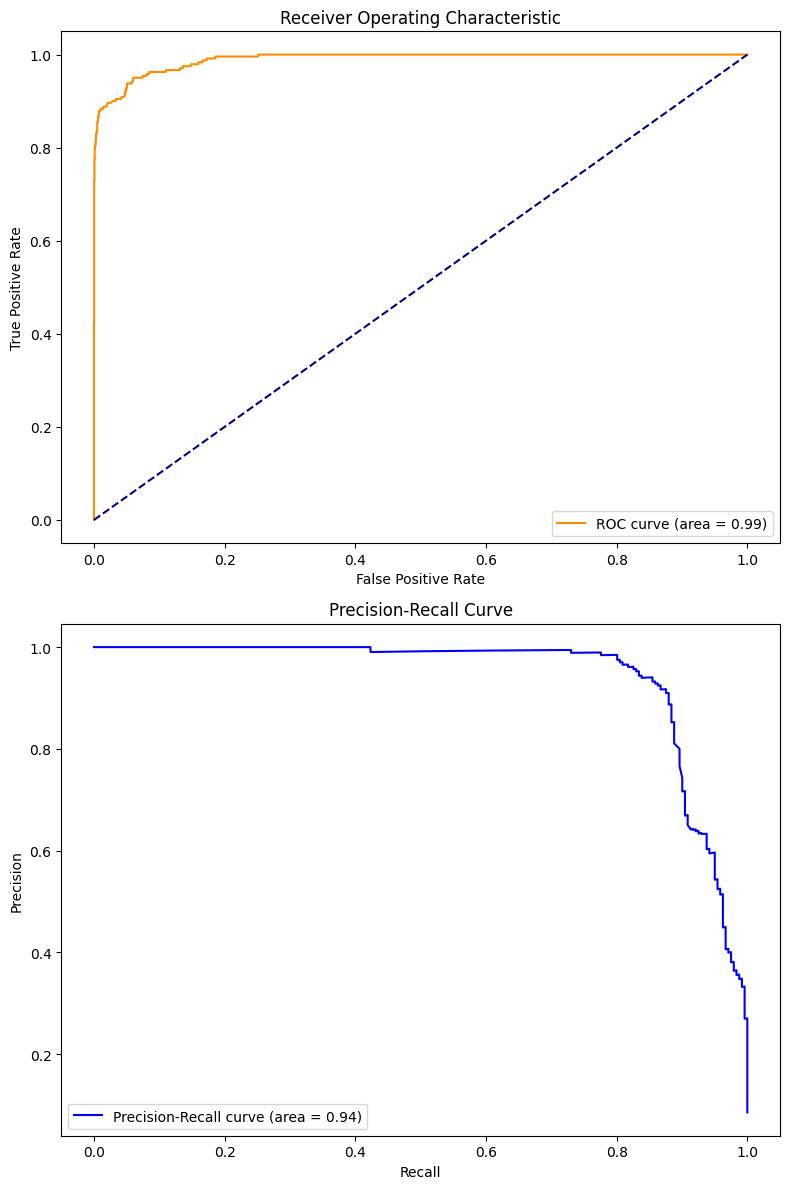

In [21]:
evaluate_cnn_model(model, X_test_reshaped, y_test)